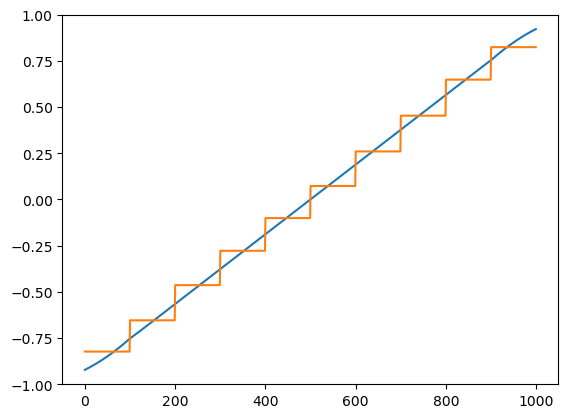

<BarContainer object of 1000 artists>

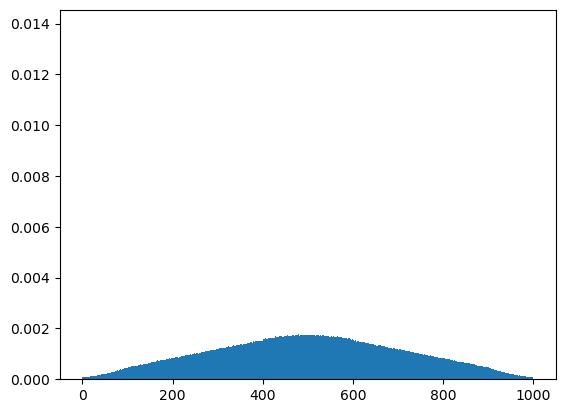

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def random_walk_true_value():
    order = 1000
    i = np.identity(order)
    t = np.zeros_like(i)
    for row in range(order):
        for col in range(order):
            dis = row - col
            if dis >= -100 and dis <= 100 and dis != 0:
                t[row][col] = 1.0/200.0

    b = np.zeros(order)
    for row in range(order):
        for n in range(100):
            if row - n - 1 < 0:
                b[row] -= 1.0/200.0
            if row + n + 1 >= order:
                b[row] += 1.0/200.0
    m = i - t
    s = np.linalg.solve(m,b)
    return s


class RandomWalk:
    def __init__(self):
        self.num_states = 1000
        self.state = self.num_states // 2
       
    def reset(self):
        self.state = self.num_states // 2 # + np.random.randint(-10,10)
        return self.state

    def step(self):
        offset = np.random.randint(-100,100)
        if offset >=0:
            offset += 1
        self.state += offset
        if self.state < 0:
            return -1, self.num_states
        elif self.state < self.num_states:
            return 0, self.state
        else:
            return 1, self.num_states

class StateAggregation:
    def __init__(self, env, num_groups):
        self.num_states = env.num_states
        self.num_groups = num_groups
        self.w = np.zeros(num_groups)

    def aggregated_state(self, state):
        return state * self.num_groups // self.num_states

    def predicate(self, state):
        agg_state = state * self.num_groups // self.num_states
        return self.w[agg_state]
    
    def train(self, state, target, alpha):
        agg_state = self.aggregated_state(state)
        v_hat = self.w[agg_state]
        self.w[agg_state] += (target - v_hat) * alpha
                
        
def gradient_monte_carlo(env, approximator, num_episodes, alpha, gamma = 1.0):
    state_stat = np.zeros(env.num_states, dtype=int)
    for episode in range(num_episodes):
        state = env.reset()
        rewards = []
        states = [state]
        while True:
            reward, next_state = env.step()
            rewards.append(reward)
            if next_state >= env.num_states:
                break
            states.append(next_state)
            state_stat[state] += 1
            state = next_state
        g = 0
        for t in range(len(rewards)-1,-1,-1):
            g = g*gamma + rewards[t]
            approximator.train(states[t], g, alpha)
    return state_stat


true_value = random_walk_true_value()
env = RandomWalk()
approximator = StateAggregation(env,10)
state_stat = gradient_monte_carlo(env, approximator, 100000, 2e-5)

v_hats = np.zeros(env.num_states)
for s in range(env.num_states):
    v_hats[s] = approximator.predicate(s)

state_dist = state_stat/state_stat.sum()
plt.ylim((-1,1))
plt.plot(range(len(true_value)),true_value)
plt.plot(range(len(v_hats)), v_hats)
plt.show()

bar = state_dist.reshape((-1,10)).sum(axis=1)
plt.bar(range(len(state_dist)), state_dist, width=1)
